In [19]:
pip install -r ../requirements.txt > /dev/null

Note: you may need to restart the kernel to use updated packages.


In [20]:
pip install job-offer-classifier --upgrade > /dev/null

Note: you may need to restart the kernel to use updated packages.


In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# default 

In [23]:
from os import path,listdir
from shutil import rmtree
import pandas as pd
import numpy as np
import job_offer_classifier
from job_offer_classifier.pipeline_classifier import Pipeline
from job_offer_classifier.validations import KFoldPipe
from job_offer_classifier.pipeline_classifier import plot_confusion_matrix

In [24]:
job_offer_classifier.__version__

'0.0.5'

In [25]:
# Shutdown TF info logging
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Balance the dataset

In [26]:
intekglobal_data = '../data/interim/intekglobal_employee/emails.csv'
sibatel_web_data = '../data/raw/sibatel_and_webpage.csv'
processed_data_file = '../data/processed/annotated_emails.csv'
models_dir = '/models/'
estimator_dir = path.join(models_dir,'estimator')

In [27]:
path.isdir(models_dir)

True

Cibatel+webpage

In [29]:
df = pd.read_csv(sibatel_web_data)
nb_cases = min([min(df.sentiment.value_counts().values),50])
df_pos = df[df.sentiment == 1].sample(nb_cases)
df_neg = df[df.sentiment == 0].sample(nb_cases)

df_sibatel_web = pd.concat([df_pos,df_neg]).sample(frac = 1)
df_sibatel_web['mocker'] = 'Enrique'

Intekglobal

In [30]:
df = pd.read_csv(intekglobal_data)
df = df[(df.sentiment == 'positive') | (df.sentiment == 'negative')]
df.sentiment = df.sentiment.apply(lambda s: int(s == 'positive'))

df_intekglobal = df
del df

All

In [31]:

df = pd.concat([df_sibatel_web,df_intekglobal]).sample(frac=1)
df.to_csv(processed_data_file)

In [32]:
df.sentiment.value_counts()

1    109
0     88
Name: sentiment, dtype: int64

In [34]:
kfp = KFoldPipe(n_splits = 4,src_file=processed_data_file)
kfp.train_steps = 2000

In [35]:
kfp.k_fold_validation()

In [36]:
kfp.best_seed

3532643550

In [37]:
kfp.random_state = kfp.best_seed
kfp.pipeline()

In [38]:
rmtree(estimator_dir,ignore_errors=True)
kfp.export_estimator(estimator_dir)

In [39]:
kfp = KFoldPipe(n_splits =1,src_file=processed_data_file,estimator_dir=estimator_dir)
kfp.load_estimator()
kfp.input_fns()

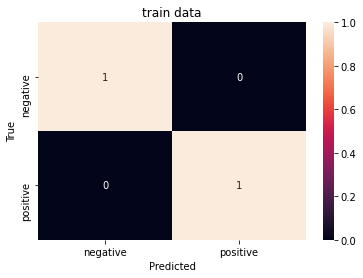

In [40]:
kfp.plot_confusion_matrix('train')

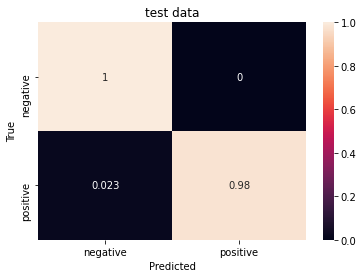

In [41]:
kfp.plot_confusion_matrix('test')

In [42]:
kfp.evaluate()
kfp.evaluation['test']

{'accuracy': 0.98734176,
 'accuracy_baseline': 0.556962,
 'auc': 0.9993506,
 'auc_precision_recall': 0.99948925,
 'average_loss': 0.043225896,
 'label/mean': 0.556962,
 'loss': 0.043225896,
 'precision': 1.0,
 'prediction/mean': 0.5500214,
 'recall': 0.97727275,
 'global_step': 10000,
 'f1_score': 0.9885057582142078}

In [43]:
df_ex = kfp.dfs['test'].sample(5)
df_ex['prediction'] = kfp.predict(df_ex)

for k, r in df_ex.iterrows():
    print(k, sep='\n')
    print(
        r.payload.strip(),
        f'Expected: {r.sentiment}',
        f'Predicted: {r.prediction}',
        sep='\n'
    )

89
Dear Joe,

Thank you for offering me the position of Web Developer. I will take the job offer. I am willing to contribute to the company's growing ambitions.

As we discuss previously, I agree with the monthly income of $ 9,500 and all the benefits after 2 months. Additionally, I need assistance with relocation as we both agreed.

Please, feel free to contact me if I need to send further documentation. I look forward to meeting you and the team on July 6, 2021.

Best regards,
Salvatore Falconi
Expected: 1
Predicted: 1
119
i hope you’re doing well.
unfortunately, i have decided to pursue another opportunity rather than accepting this offer.
i appreciate the time you and your team spent meeting with me and putting together this offer, and i wish you luck in finding
the right person for the job.
Expected: 0
Predicted: 0
7
I'm going to have to pass up the offer, they increased my salary
Expected: 0
Predicted: 0
9
thank you so much for considering me for the position of Primary school te

The dataset consists of mock emails by the Intekglobal employees. 

Convert 'positive' and 'negative' values to 1 and 0 values, respectively.